![banner-pdi](https://user-images.githubusercontent.com/58775072/141189378-b5df3287-e8c0-48a1-ad11-825ba317463b.png)

## Universidade Federal de Campina Grande (UFCG)
## Centro de Engenharia Elétrica e Informática (CEEI) 
## Disciplina: Int. ao Processamento de Imagem Digital e Visão Computacional
## Professora: Luciana Ribeiro Veloso
## Aluno(a): Coloque seu nome aqui

# <span style="color:brown">Experimento 05: Segmentação - Pt. 1</span>
***

## Sumário de Conteúdos

* [0. Importação dos Pacores](#0)
* [1. Funções Auxiliares](#1)
* [2. Detecção de Bordas](#2)
* [3. Aplicação em Outras Imagens](#3)
* [4. Prewitt e Sobel](#4)
* [5. Detector de Canny](#5)

## <span style='color:red'>Observações</span>
***

1. Os arquivos de laboratório devem ser salvos seguindo o seguinte padrão: `lab-x-nome-sobrenome.ipynb`.
2. Não esqueça de colocar o seu nome no cabeçalho acima.
3. Não altere a ordem das células e realize as implementações somente nos campos específicados.  
4. Ao longo do laboratório será solicitado perguntas teóricas relativas aos assuntos das aulas da disciplina e implementações de código utilizando a linguagem de programação Python. 
5. <span style='color:blue'>As células com as perguntas estão representadas pela cor azul</span>. <span style='color:green'>As células de resposta teórica estão representadas pela cor verde</span>.
6. As células de implementação com código serão indicadas pelos seguintes comentários: `# IMPLEMENTE O SEU CÓDIGO AQUI`.
7. Para editar uma célula de texto, basta clicar duas vezes com o cursos do mouse para editar, e `Ctrl + Enter` para finalizar a edição. 
8. Para rodar as células com os códigos desenvolvidos, digite `Ctrl + Enter` ou clique em `Run` no menu do Jupyter.
9. Dúvidas, problemas de execução de código ou dificuldades com a linguagem de programação Python devem ser feitas durante as aulas de laboratório, encaminhadas para o grupo de WhatsApp da turma ou fórum do PVAE da disciplina.
10. Os laboratórios devem ser enviados nos campos especificados pelo PVAE. <span style='color:red'>ATENTE-SE AOS PRAZOS DE ENTREGA!</span>

## Importação dos Pacotes

In [1]:
import os                            # Operational System para manipulação de arquivos.
import cv2                           # OpenCV para manipulação de imagens.
import numpy as np                   # Numpy para manipulação de matrizes e arrays.
import matplotlib.pyplot as plt      # Pyplot para plotagem de gráficos e imagens.

In [6]:
import urllib.request as url         # urllib para baixar arquivos via HTTPS
import zipfile                

# baixando as imagens de referência
url.urlretrieve('https://github.com/Alyssonmach/pdi-labs/raw/main/imagens.zip', 'imagens.zip')
with zipfile.ZipFile('imagens.zip', 'r') as zip_ref:
    zip_ref.extractall('')

## Funções Auxiliares

In [2]:
def ruido_gaussiano(img, media, var):
    """ Introduz ruido gaussiano na imagem """
    
    return img + np.random.normal(media, var, img.shape)

In [3]:
def display_values(ax, im):
    """ Escreve os valores na imagem """
    
    import matplotlib.patheffects as PathEffects
    h, w = im.shape[:2]
    for x in range(w):
        for y in range(h):
            txt = ax.text(x, y, im[y, x], color="lime", ha="center", va="center")
            txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground="black")])
    return

In [4]:
def custom_padding(src_img):
    """ Aplica zero-padding à imagem """
    
    H, W = src_img.shape
    padded = np.zeros( (H+2, W+2) )
    padded[1:H+1, 1:W+1] = src_img
    return padded

In [7]:
def edge_detector(relative_directory, image,T=0.1, mu=30, sigma=7.5):
    '''Detector de bordas'''

    src_img = cv2.imread( os.path.join(".", relative_directory, image), 0 )
    gau_img = ruido_gaussiano(src_img, mu, sigma)
    kernel  = np.array( [ [-1, -1, -1], [-1,  8, -1], [-1, -1, -1] ], dtype = np.int16 )
    flt_img = cv2.filter2D( gau_img, cv2.CV_64F, kernel )
    abs_img = np.abs(flt_img)
    threshold = int(T * np.max(abs_img))
    _, dst_img = cv2.threshold(abs_img, threshold, 255, cv2.THRESH_BINARY)
    blr_img = cv2.GaussianBlur( gau_img, (5, 5), 1.4)
    flt_img_2 = cv2.filter2D( blr_img, cv2.CV_64F, kernel )
    abs_img_2 = np.abs(flt_img_2)
    threshold = int(T * np.max(abs_img_2))
    _, dst_img_2_a = cv2.threshold(abs_img_2, threshold, 255, cv2.THRESH_BINARY)
    
    return dst_img_2_a

## Detecção de Bordas

A biblioteca OpenCV disponibiliza diversas funções para a aplicação de filtros espaciais, a exemplo de:

1. **Filtro Gaussiano**:  
    * Filtro passa-baixas gaussiano de altura H, largura W e desvio padrão sigma.
    * `dst_img = cv2.GaussianBlur( src_img, (H, W), sigma)`
    * O filtro na direção y pode ser obtido utilizando: `kernel_y = cv2.getGaussianKernel(H, sigma, ktype = dtype)`
    * O filtro na direção x pode ser obtido ao transpor o filtro acima: `kernel_x = kernel_y.T`
    * Um filtro 2D pode ser obtido a partir do produto vetorial (`np.dot()`) entre os filtros.
2. **Filtro Laplaciano**:
    * Filtro que aproxima a operação de Laplaciano retornando uma imagem tipo dtype.
    * dtype deve ser especificado segundo flags do OpenCV: cv2.CV_8U para uint8, cv2.CV_32F para float32, cv2.CV_16S para int16, etc.
    * `dst_img = cv2.Laplacian(src_gray, dtype)` 
3. **Filtragem arbitrária**:
    * O OpenCV também disponibiliza uma função para filtragem espacial 2D a partir de uma imagem de entrada e um filtro (kernel).
    * Essa função implementa a filtragem de maneira limitada, permitindo apenas a produção de saídas com mesmas dimensões da entrada.
    * Para garantir que a entrada e a saída tenham a mesma dimensão a imagem é preenchida com zeros antes da convolução.
    * `dst_img = cv2.filter2D( src_img, dtype, kernel )`

 ## <span style='color:blue'>Questão 1: [Valor da Questão: 2.5][Taxa de acerto: x.x]</span>
<span style="color:blue"> **O código abaixo realiza a detecção de bordas da imagem “Fig0458(a)(blurry_moon).tif” após a introdução de ruído gaussiano. Explique o funcionamento do código abaixo e responda as perguntas a seguir.**</span>
 * (a) <span style="color:blue">Qual é o propósito da suavização na detecção de bordas?</span>
 * (b) <span style="color:blue">Reduza o ruído ao setar mu = 0 e sigma = 3, depois retire o ruído setando mu = sigma = 0. O filtro utilizado é sensível ao ruído?</span>
 * (c) <span style="color:blue">Qual a função da variável T? Ajuste a variável para valores entre [0, 1] e comente os resultados observados.</span>
 * (d) <span style="color:blue">Na sua opinião, qual o melhor valor de T para a detecção de bordas nessa imagem com esse filtro? Justifique.</span>

Text(0.5, 1.0, 'Bordas c/ Suavização')

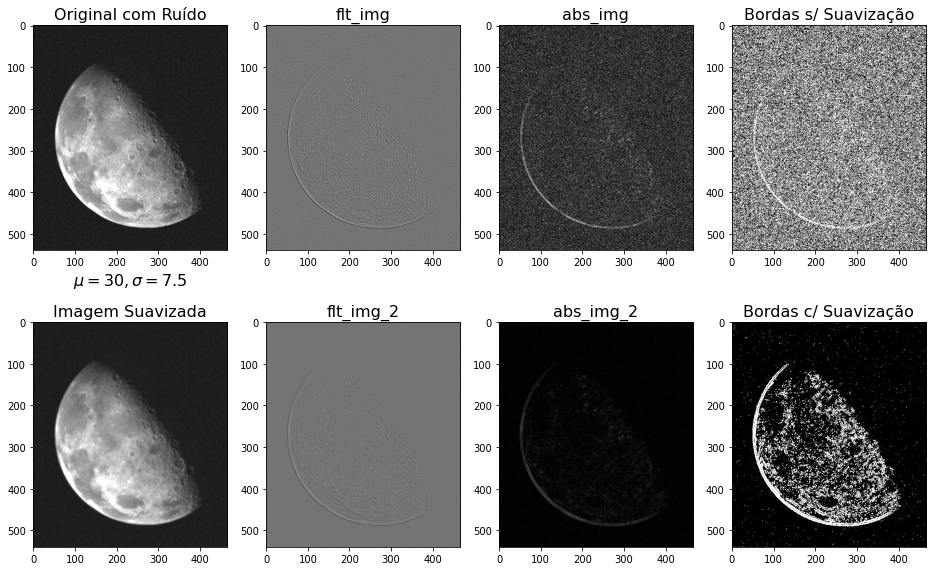

In [5]:
T = 0.1
mu = 30
sigma = 7.5

# A função 'os.path.join' concatena textos para produzir caminhos de arquivos que serão válidos 
# independentemente do sistema operacional utilizado.
src_img = cv2.imread("imagens/Fig0338(a)(blurry_moon).tif",0)

# Primeira imagem da primeira linha
gau_img = ruido_gaussiano(src_img, mu, sigma)

# Segunda imagem da primeira linha
kernel  = np.array( [ [-1, -1, -1], [-1,  8, -1], [-1, -1, -1] ], dtype = np.int16 )
flt_img = cv2.filter2D( gau_img, cv2.CV_64F, kernel )

# Terceira imagem da primeira linha
abs_img = np.abs(flt_img)

# Quarta imagem da primeira linha
threshold = int(T * np.max(abs_img))
_, dst_img = cv2.threshold(abs_img, threshold, 255, cv2.THRESH_BINARY)

# Primeira imagem da segunda linha
blr_img = cv2.GaussianBlur( gau_img, (5, 5), 1.4)

# Segunda imagem da primeira linha
flt_img_2 = cv2.filter2D( blr_img, cv2.CV_64F, kernel )

# Terceira imagem da primeira linha
abs_img_2 = np.abs(flt_img_2)

# Quarta imagem da primeira linha
threshold = int(T * np.max(abs_img_2))
_, dst_img_2_a = cv2.threshold(abs_img_2, threshold, 255, cv2.THRESH_BINARY)

# Plotagem
fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize=(16, 10))

# Primeira Subfigura da primeira linha
axs[0][0].imshow(gau_img, vmin=0, vmax=255, cmap="gray")
axs[0][0].set_title("Original com Ruído", fontsize = 16)
axs[0][0].set_xlabel(r"$\mu = {}, \sigma = {}$".format(mu, sigma), fontsize = 16)

# Segunda Subfigura da primeira linha
axs[0][1].imshow(flt_img, vmin=np.min(flt_img), vmax=np.max(flt_img), cmap="gray")
axs[0][1].set_title("flt_img", fontsize = 16)

# Terceira Subfigura da primeira linha
axs[0][2].imshow(abs_img, vmin=0, vmax=255, cmap="gray")
axs[0][2].set_title("abs_img", fontsize = 16)

# Quarta Subfigura da primeira linha
axs[0][3].imshow(dst_img, vmin=0, vmax=255, cmap="gray")
axs[0][3].set_title("Bordas s/ Suavização", fontsize = 16)

# Primeira Subfigura da segunda linha
axs[1][0].imshow(blr_img, vmin=0, vmax=255, cmap="gray")
axs[1][0].set_title("Imagem Suavizada", fontsize = 16)

# Segunda Subfigura da primeira linha
axs[1][1].imshow(flt_img_2, vmin=np.min(flt_img), vmax=np.max(flt_img), cmap="gray")
axs[1][1].set_title("flt_img_2", fontsize = 16)

# Terceira Subfigura da primeira linha
axs[1][2].imshow(abs_img_2, vmin=0, vmax=255, cmap="gray")
axs[1][2].set_title("abs_img_2", fontsize = 16)

# Quarta Subfigura da primeira linha
axs[1][3].imshow(dst_img_2_a, vmin=0, vmax=255, cmap="gray")
axs[1][3].set_title("Bordas c/ Suavização", fontsize = 16)

## <span style='color:green'>Respostas da Questão 1:</span>

* (a) <span style='color:green'>Adicione sua resposta aqui.</span>
* (b) <span style='color:green'>Adicione sua resposta aqui.</span>
* (c) <span style='color:green'>Adicione sua resposta aqui.</span>
* (d) <span style='color:green'>Adicione sua resposta aqui.</span>

## Prewitt e Sobel
A detecção de bordas também pode ser realizada a partir dos filtros de Sobel e Prewitt:

* **Prewitt**:
    * `kernel_x    = [ [-1, -1, -1], [ 0,  0,  0], [ 1,  1,  1] ]` 
    * `kernel_y    = [ [-1,  0,  1], [-1,  0,  1], [-1,  0,  1] ]` 
    * `kernel_diag = [ [-1, -1,  0], [-1,  0,  1], [ 0,  1,  1] ]`

* **Sobel**:
    * `kernel_x    = [ [-1, -2, -1], [ 0,  0,  0], [ 1,  2,  1] ]` 
    * `kernel_y    = [ [-1,  0,  1], [-2,  0,  2], [-1,  0,  1] ]` 
    * `kernel_diag = [ [-2, -1,  0], [-1,  0,  1], [ 0,  1,  2] ]`
    
* **Descrição**:  
    * **kernel_x** detecta bordas horizontais;
    * **kernel_y** detecta bordas verticais;
    * **kernel_diag** detecta bordas diagonais (+45°);

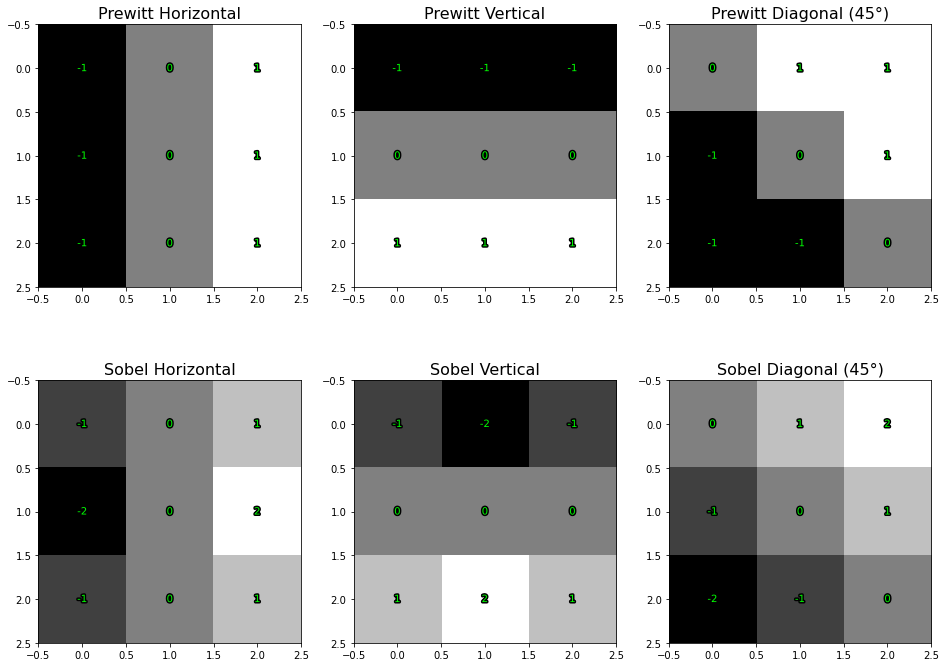

In [8]:
# Prewitt
prewitt_x    = np.array( [ [-1,  0,  1], [-1, 0,  1], [-1,  0, 1] ], dtype = np.int8 )
prewitt_y    = np.array( [ [-1, -1, -1], [ 0, 0,  0], [ 1,  1, 1] ], dtype = np.int8 )
prewitt_diag = np.array( [ [ 0,  1,  1], [-1, 0,  1], [-1, -1, 0] ], dtype = np.int8 )

# Sobel
sobel_x    = np.array( [ [-1,  0,  1], [-2, 0,  2], [-1, 0, 1] ], dtype = np.int8 )
sobel_y    = np.array( [ [-1, -2, -1], [ 0, 0,  0], [ 1, 2, 1] ], dtype = np.int8 )
sobel_diag = np.array( [ [ 0,  1,  2], [-1, 0,  1], [-2,-1, 0] ], dtype = np.int8 )

# Plots
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(16, 12))

# Primeira Subfigura da primeira linha
axs[0][0].imshow(prewitt_x, vmin=-1, vmax=1, cmap="gray")
axs[0][0].set_title("Prewitt Horizontal", fontsize = 16)
display_values(axs[0][0], prewitt_x)

# Segunda Subfigura da primeira linha
axs[0][1].imshow(prewitt_y, vmin=-1, vmax=1, cmap="gray")
axs[0][1].set_title("Prewitt Vertical", fontsize = 16)
display_values(axs[0][1], prewitt_y)

# Terceira Subfigura da primeira linha
axs[0][2].imshow(prewitt_diag, vmin=-1, vmax=1, cmap="gray")
axs[0][2].set_title("Prewitt Diagonal (45°)", fontsize = 16)
display_values(axs[0][2], prewitt_diag)

# Primeira Subfigura da segunda linha
axs[1][0].imshow(sobel_x, vmin=-2, vmax=2, cmap="gray")
axs[1][0].set_title("Sobel Horizontal", fontsize = 16)
display_values(axs[1][0], sobel_x)

# Segunda Subfigura da segunda linha
axs[1][1].imshow(sobel_y, vmin=-2, vmax=2, cmap="gray")
axs[1][1].set_title("Sobel Vertical", fontsize = 16)
display_values(axs[1][1], sobel_y)

# Terceira Subfigura da segunda linha
axs[1][2].imshow(sobel_diag, vmin=-2, vmax=2, cmap="gray")
axs[1][2].set_title("Sobel Diagonal (45°)", fontsize = 16)
display_values(axs[1][2], sobel_diag)

 ## <span style='color:blue'>Questão 2: [Valor da Questão: 2.5][Taxa de acerto: x.x]</span>
* (a) <span style="color:blue"> **Aplique as diferentes versões dos filtros de Prewitt em quatro figuras da pasta de imagens. Comente os resultados obtidos.**</span>
    * <span style="color:blue">Lembre de computar o módulo das imagens após a filtragem.</span>
    * <span style="color:blue">Defina vmin e vmax de acordo com o menor/maior valores da imagem.</span>

In [9]:
def my_edge_detector(image, kernel, T_rate=0.1):
    '''Detector de borda com kernel personalizado'''
    
    src_img = image
    k = np.array(kernel, dtype='int16')
    blr_img = cv2.GaussianBlur(src_img, (5,5), 1.4)
    flt_img = cv2.filter2D(blr_img, cv2.CV_64F, k)
    abs_img = np.abs(flt_img)
    
    threshold = int(T_rate * np.max(abs_img))
    _, dst_img = cv2.threshold(abs_img, threshold, 255, cv2.THRESH_BINARY)
    
    return dst_img 

In [10]:
# filtros prewitt
kernel_x    = [[-1, -1, -1],[ 0,  0,  0],[ 1,  1,  1]]
kernel_y    = [[-1,  0,  1],[-1,  0,  1],[-1,  0,  1]]
kernel_diag = [[-1, -1,  0],[-1,  0,  1],[ 0,  1,  1]]

In [11]:
# IMPLEMENTE SEU CÓDIGO AQUI -> QUESTÃO 2 letra (a)


## <span style='color:green'>Respostas da Questão 2:</span>

* (a) <span style='color:green'>Adicione sua resposta aqui.</span>

* <span style="color:green">Observando as imagens obtidas, é possível perceber o efeito dos filtros *prewitt*. Nelas, é visível o efeito dos filtros que detectam bordas horizontais, verticais e diagonais. Desse modo, a aplicação do filtro *prewitt* para detecção de bordas em imagens produz resultados consistentes.</span>

* (b) <span style="color:blue"> **Aplique as diferentes versões dos filtros de Sobel em quatro figuras da pasta de imagens. Comente os resultados obtidos.**</span>

In [149]:
# filtros sobel
kernel_x    = [[-1, -2, -1],[ 0,  0,  0],[ 1,  2,  1] ]
kernel_y    = [[-1,  0,  1],[-2,  0,  2],[-1,  0,  1] ]
kernel_diag = [[-2, -1,  0],[-1,  0,  1],[ 0,  1,  2] ]

In [12]:
# IMPLEMENTE SEU CÓDIGO AQUI -> QUESTÃO 2 letra (b)


## <span style='color:green'>Respostas da Questão 2:</span>

* (b) <span style='color:green'>Adicione sua resposta aqui.</span>

 ## <span style='color:blue'>Questão 3: [Valor da Questão: 2.5][Taxa de acerto: x.x]</span>
* <span style="color:blue">**Escreva uma função que detecta bordas horizontais e verticais utilizando os filtros de Sobel. A função deve retornar uma única imagem com o somatório das máscaras produzidas. Valide sua função em pelo menos 4 figuras da pasta de imagens. Comente os resultados.**</span>

In [13]:
# IMPLEMENTE SEU CÓDIGO AQUI -> QUESTÃO 3


## <span style='color:green'>Respostas da Questão 3:</span>

* <span style='color:green'>Adicione sua resposta aqui.</span>

## Detector de Canny

Uma alternativa mais robusta para a detecção de bordas é o detector de Canny, que se propõe a detectar as bordas mais finas possíveis com uma menor frequência de falsos postivos (bordas falsas). Esse algoritmo corresponde à sequência dos seguintes passos:

1. Suavizar a imagem com  filtro gaussiano.   
2. Cálculo da magnitude e da fase referentes ao gradiente das imagens.     
3. Aplicar a supressão não máxima na imagem da magnitude do gradiente.   
4. Usar a dupla limiarização e a análise de conectividade para detectar e conectar as bordas.   

In [14]:
def get_refmat(shape):
    """ Cria uma matriz de referência de dimensões (H, W, 4). Cada um dos seus canais corresponde a um valor
    de referência, sendo todos os elementos dos canais 0, 1, 2 e 3 iguais a 0°, 45°, 90° e 135°, respectivamente. """
    H, W = shape[:2]
    mat = np.zeros( (H, W, 4) )
    mat[:, :, 1] = 45
    mat[:, :, 2] = 90
    mat[:, :, 3] = 135
    return mat

In [15]:
def round_angles(angles):
    """ Ajusta os valores dos ângulos para identificar bordas a 0°, 45°, 90° e 135° """
    H, W = angles.shape[:2]
    
    # Corrige valores de ângulo negativos
    angles[ angles < 0 ] += 180
    angles[ angles > 157.5 ] = 0
    
    # Produz uma matriz de referência de dimensões H, W, 4
    # Cada canal dessa matriz é composta apenas de um dos valores de referência: 0, 45, 90 ou 135
    ref_mat = get_refmat(angles.shape)
    
    # Calcula o erro absoluto entre os ângulos e os elementos da matriz de referência
    # Em uma subtração de matrizes (H, W, 4) - (H, W, 1) o numpy repete a última matriz 4x para igualar as dimensões
    # Após essa repetição a operação pode ser realizada e retorna um array (H, W, 4)
    # Mais informações: https://numpy.org/devdocs/user/basics.broadcasting.html
    dif_mat = np.abs( ref_mat - angles.reshape( (H, W, 1) ) )
    
    # Aplica o argmin pra identifiar o menor erro absoluto entre um ângulo e um elemento de dif_mat
    # O retorno é o índice do elemento que, multiplicado por 45 produz o próprio elemento
    # Isso equivale a arredondar os ângulos para o valor mais próximo entre 0, 45, 90 e 135,
    # mas sem utilizar laços (fors / while), o que é mais eficiente.
    rounded_mat = 45 * np.argmin( dif_mat, axis = -1 )
    return rounded_mat

In [16]:
def get_edge_grad_mask(angle):
    """ Produz uma máscara para filtrar a vizinhança na supressão não máxima.
    A máscara elimina os valores dos pixels que não estão na direção do gradiente."""
    # Força um erro se o valor do ângulo é diferente dos valores esperados.
    assert angle in [0, 45, 90, 135]
    
    # Retorna a máscara correspondente ao ângulo.
    if angle == 0:
        return np.array([ [0, 0, 0], [1, 1, 1], [0, 0, 0] ])
    if angle == 45:
        return np.array([ [0, 0, 1], [0, 1, 0], [1, 0, 0] ])
    if angle == 90:
        return np.array([ [0, 1, 0], [0, 1, 0], [0, 1, 0] ])
    if angle == 135:
        return np.array([ [1, 0, 0], [0, 1, 0], [0, 0, 1] ])

In [17]:
def non_max_supression(abs_img, ang_img):
    """ Realiza a Supressão não máxima """
    H, W = abs_img.shape
    
    # Aplica padding ao modulo e à fase
    pad_abs = custom_padding(abs_img)
    pad_ang = custom_padding(ang_img)
    
    # Instancia a matriz de saída
    output = np.zeros((H, W))
    
    # Itera os pixels
    for i in range(1, H+1):
        for j in range(1, W+1):
            
            # Ignora um elemento se ele é igual a 0
            if pad_abs[i][j] == 0:
                continue
            
            # Extrai as vizinhanças de módulo e aplica uma máscara para
            # eliminar os elementos que não estão na direção do gradiente da borda
            n8_abs = pad_abs[(i-1):(i+2), (j-1):(j+2)]
            n8_abs *= get_edge_grad_mask( pad_ang[i][j] )
            
            # Se o módulo do pixel atual for igual ao máx da vizinhança 
            # restrita aos pixels com mesma fase:
            if np.max(n8_abs) == pad_abs[i][j]:
                # O pixel atual é adicionado à saída;
                # Caso contrário ele é ignorado;
                output[i-1, j-1] = pad_abs[i, j]
    
    return output

In [18]:
def custom_histerese(src_img, lmin, lmax):
    """ Realiza a Limiarização por Histerese """
    
    # Instancia a matriz de saída
    output = np.zeros(src_img.shape)
    
    # Considera todas as bordas acima de lmax como bordas fortes
    strong_edges = src_img * (src_img > lmax)
    
    # Produz uma nova matriz só com as bordas fracas e ignora as bordas fortes
    weak_edges = (src_img - strong_edges) * (lmin < src_img)
    
    # Aplica padding na imagem com bordas fortes
    pad_str = custom_padding(strong_edges)
    
    # Itera weak_edges para identificar bordas fracas conectadas a bordas fortes
    for i in range(1, weak_edges.shape[0]+1):
        for j in range(1, weak_edges.shape[1]+1):
            # Ignora se o pixel atual é 0 (não é uma borda fraca)
            if weak_edges[i-1, j-1] == 0 :
                continue
            
            # Identifica a vizinhança do elemento analisado nessa iteração
            n8_str = pad_str[(i-1):(i+2), (j-1):(j+2)]
            
            # Testa se existe algum elemento na vizinhança que seja uma borda forte
            if np.max(n8_str) > lmax:
                # Se sim, considera a borda fraca como uma borda real
                output[i-1, j-1] = 255
    
    # Adiciona as bordas fortes à saída
    output[strong_edges > 0] = 255
                
    return output

In [19]:
def custom_canny(src_img, L_min, L_max):
    # Se a imagem não está em escala de cinza, converte de BGR para escala de cinza
    if len(src_img.shape) > 2:
        src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2GRAY)
    
    # Passo 1: Suavizar a imagem com um filtro Gaussiano
    img = cv2.GaussianBlur( src_img, (3, 3), 0 )
    
    # Passo 2: Calcula a magnitude do gradiente e os ângulos das imagens
    
    # Aplica Sobel na horizontal
    sobel_x = np.array( [ [-1,  0,  1], [-2, 0,  2], [-1, 0, 1] ], dtype = np.float64 )
    Gx = cv2.filter2D( img, cv2.CV_64F, sobel_x )
    
    # Aplica Sobel na vertical
    sobel_y = np.array( [ [-1, -2, -1], [ 0, 0,  0], [ 1, 2, 1] ], dtype = np.float64 )
    Gy = cv2.filter2D( img, cv2.CV_64F, sobel_y )
    
    # Calcula a magnitude do gradiente
    G_abs = np.sqrt( Gx**2 + Gy**2 )
    G_ang = np.arctan2( Gy, Gx ) * 180 / np.pi
    
    # Ajusta os valores dos ângulos para identificar bordas a 0°, 45°, 90° e 135°
    G_ang = round_angles(G_ang)
    
    # Passo 3: Supressão não máxima
    G_sup = non_max_supression(G_abs, G_ang)
    
    # Passo 4: Limiarização por Histerese
    G_hist = custom_histerese(G_sup, L_min, L_max)
    
    return G_hist

 ## <span style='color:blue'>Questão 4: [Valor da Questão: 2.0][Taxa de acerto: x.x]</span>
* <span style="color:blue">**O código das células abaixo implementa um detector de Canny. Execute-as e comente os resultados observados.**</span>
 * <span style="color:blue">Atente-se à espessura das bordas e o tempo de execução do algoritmo.</span>
 * <span style="color:blue">Como esse algoritmo se compara com relação aos outros detectores de bordas vistos neste experimento?</span>

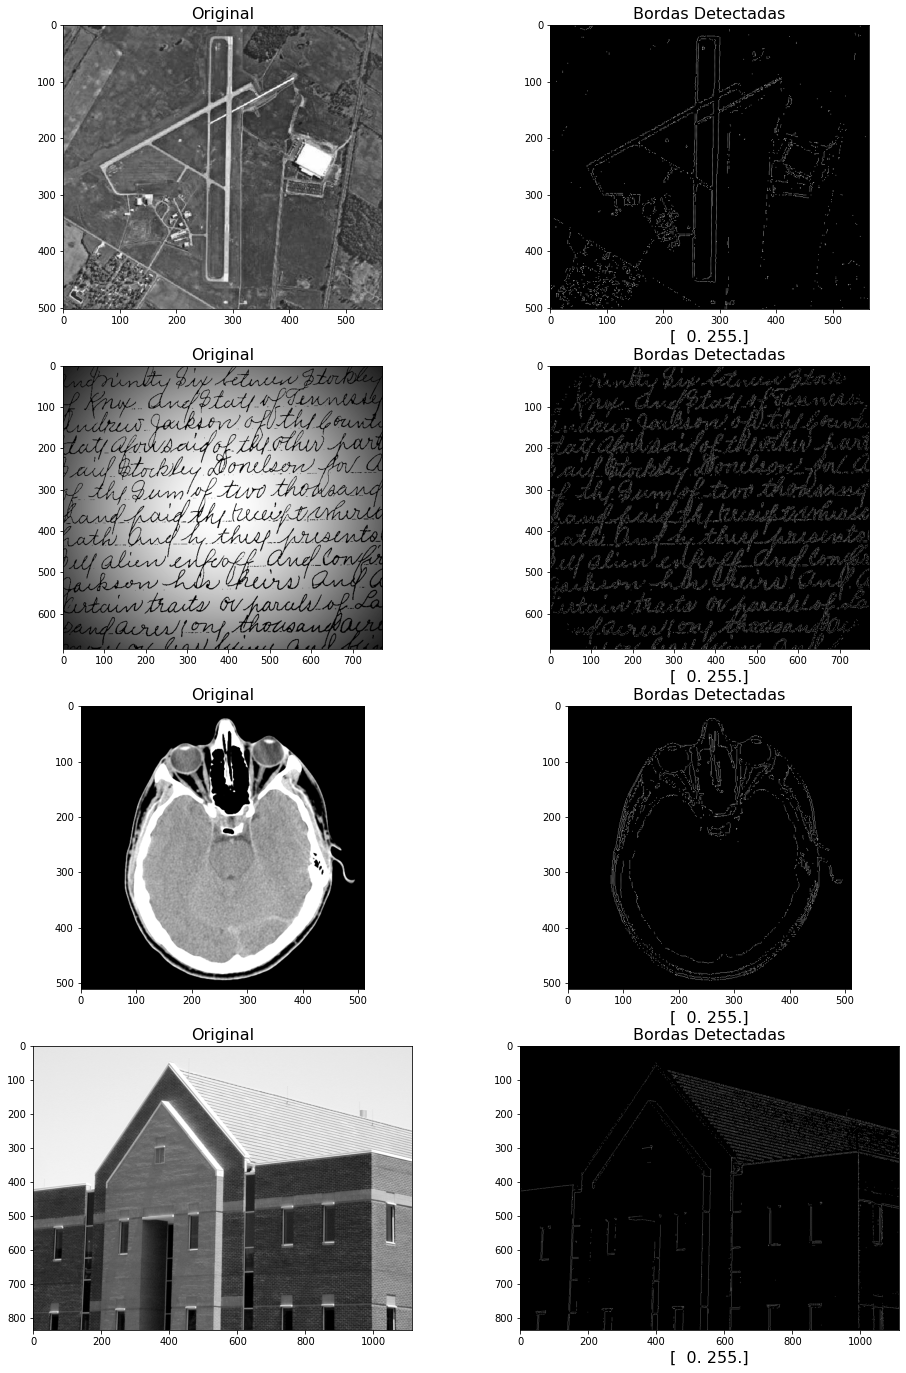

In [20]:
lista = ["imagens/Fig1034(a)(marion_airport).tif",
         "imagens/Fig1049(a)(spot_shaded_text_image).tif",
         "imagens/Fig1026(a)(headCT-Vandy).tif",
         "imagens/Fig1016(a)(building_original).tif",]

# Plots
fig, axs = plt.subplots(nrows = 4, ncols = 2, figsize=(16, 24))

for i in range(4):
    
    # Imagem Original
    filepath = lista[i]
    src_img = cv2.imread(filepath, 0)
    axs[i][0].imshow(src_img, cmap="gray")
    axs[i][0].set_title("Original", fontsize = 16)
    
    # Filtragem
    dst_img = custom_canny( src_img, 90, 180 )
    axs[i][1].imshow(dst_img, vmin = 0, vmax = 255, cmap="gray")
    axs[i][1].set_title("Bordas Detectadas", fontsize = 16)
    axs[i][1].set_xlabel(str(np.unique(dst_img)), fontsize = 16)

## <span style='color:green'>Respostas da Questão 4:</span>

* <span style='color:green'>Adicione sua resposta aqui.</span>

A biblioteca OpenCV também disponibiliza funções para a detecção de bordas utilizando algumas das alternativas mais populares, como os detectores de Canny e de Sobel. A sintaxe das funções é: 

 1. `dst_img = cv2.Canny(src_img, L_min, L_max, L2gradient = False )`    
 2. `dst_img = cv2.Sobel(src_img, ddepth, x_order, y_order, ksize = 3)`   

* Descrição:
    * **dst_img** representa a imagem de saída;
    * **src_img** representa a imagem de entrada;
    * **L_min** representa o limiar inferior;
    * **L_max** representa o limiar superior;
    * **L2gradient** é um flag que indica se o gradiente deve ser calculado (True) ou aproximado (False).
    * **x_order** corresponde à ordem do gradiente na direção horizontal.
    * **y_order** corresponde à ordem do gradiente na direção vertical.
    * **ksize** corresponde ao tamanho do filtro.

O uso dessas funções é consideravelmente vantajoso, pois as funções da biblioteca são extremamente otimizadas e de fácil utilização, viabilizando o uso de técnicas robustas como o Detector de Canny em um tempo de execução reduzido e sem necessidade de implementação.

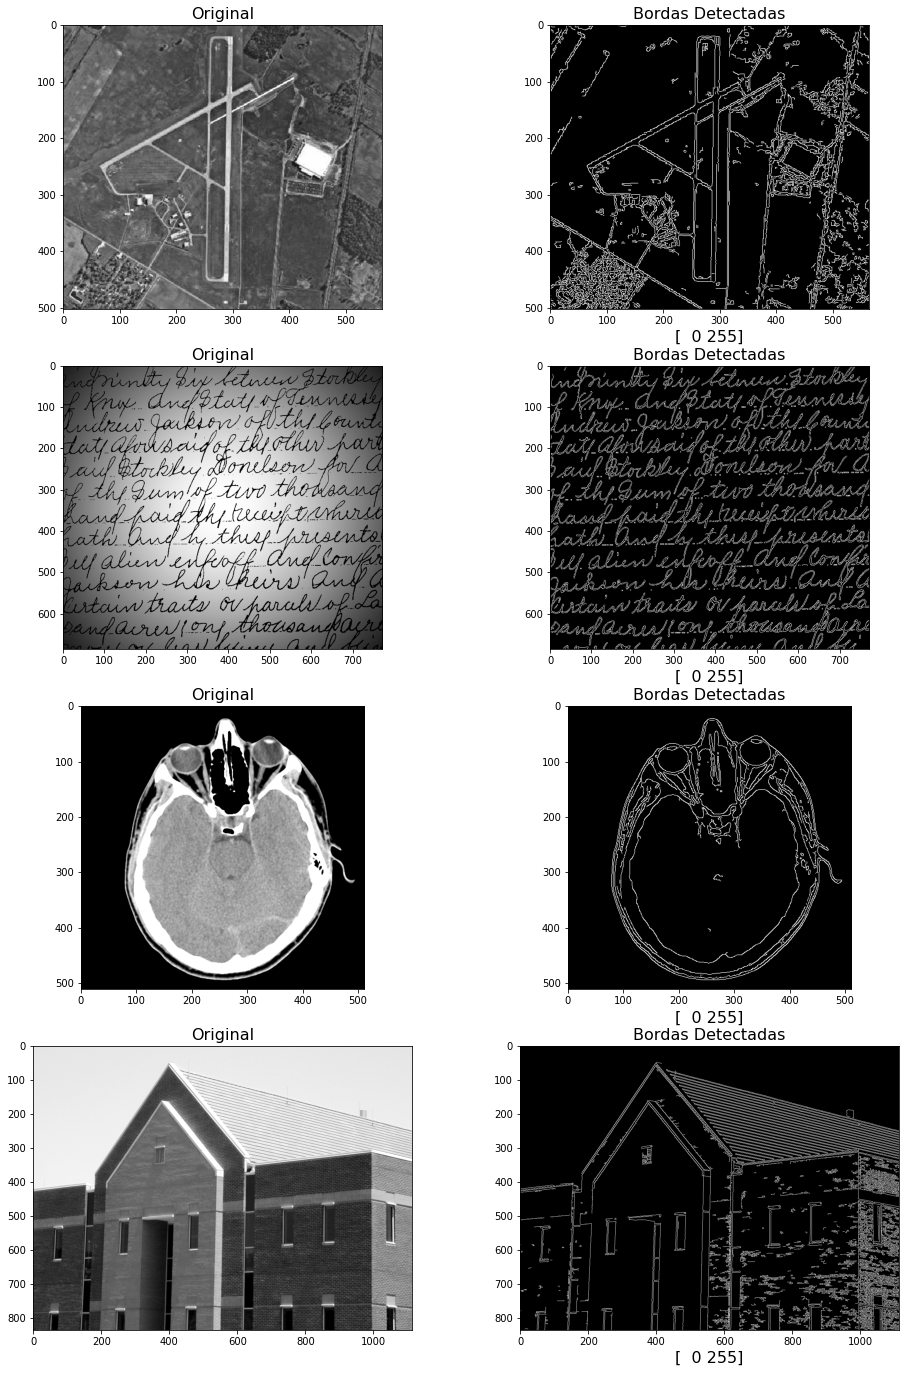

In [21]:
# Plots
fig, axs = plt.subplots(nrows = 4, ncols = 2, figsize=(16, 24))

for i in range(4):
    
    # Imagem Original
    filepath = lista[i]
    src_img = cv2.imread(filepath, 0)
    axs[i][0].imshow(src_img, cmap="gray")
    axs[i][0].set_title("Original", fontsize = 16)
    
    # Filtragem
    dst_img = cv2.Canny(src_img, 90, 180, L2gradient = True )
    axs[i][1].imshow(dst_img, vmin = 0, vmax = 255, cmap="gray")
    axs[i][1].set_title("Bordas Detectadas", fontsize = 16)
    axs[i][1].set_xlabel(str(np.unique(dst_img)), fontsize = 16)

 ## <span style='color:blue'>Questão 5: [Valor da Questão: 1.5][Taxa de acerto: x.x]</span>
* <span style="color:blue">**Meça o tempo de execução dos algoritmos de detecção de bordas de Canny e de Sobel disponibilizados pelo opencv e comente os resultados observados.**</span>

In [22]:
ex_img = cv2.imread("imagens/Fig1049(a)(spot_shaded_text_image).tif", 0 )
print("ex_img.shape:", ex_img.shape)

ex_img.shape: (686, 772)


In [23]:
%%timeit
canny_output = cv2.Canny(ex_img, 90, 180, L2gradient = True )

1.42 ms ± 255 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
%%timeit
sobel_x = cv2.convertScaleAbs(cv2.Sobel(ex_img, cv2.CV_16S, 1, 0, ksize=3))
sobel_y = cv2.convertScaleAbs(cv2.Sobel(ex_img, cv2.CV_16S, 0, 1, ksize=3))
sobel_output = sobel_x + sobel_y

1.28 ms ± 35.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## <span style='color:green'>Respostas da Questão 5:</span>

* <span style='color:green'>Adicione sua resposta aqui.</span>

 ## <span style='color:blue'>Questão 6: [Valor da Questão: 1.5][Taxa de acerto: x.x]</span>
* <span style="color:blue">**Teste algumas das figuras da pasta images na célula abaixo e comente as principais diferenças observadas entre as duas abordagens.**</span>

Text(0.5, 1.0, 'Detector de Canny')

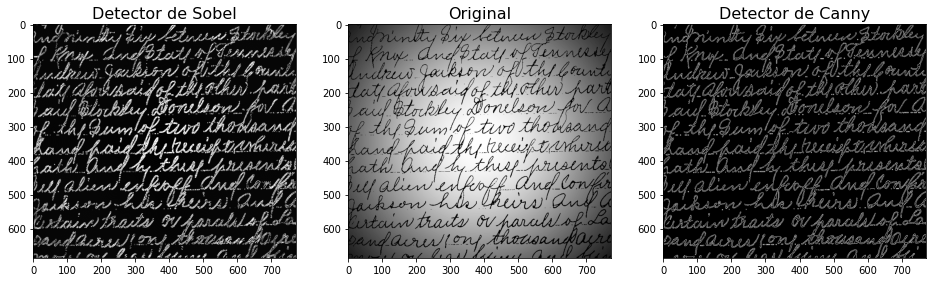

In [26]:
ex_img = cv2.imread("imagens/Fig1049(a)(spot_shaded_text_image).tif", 0 )
canny_output = cv2.Canny(ex_img, 90, 180, L2gradient = True )
sobel_x = cv2.convertScaleAbs(cv2.Sobel(ex_img, cv2.CV_16S, 1, 0, ksize=3))
sobel_y = cv2.convertScaleAbs(cv2.Sobel(ex_img, cv2.CV_16S, 0, 1, ksize=3))
sobel_output = sobel_x + sobel_y

# Plots
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(16, 24))
    
# Imagem Original
axs[1].imshow(ex_img, cmap="gray")
axs[1].set_title("Original", fontsize = 16)

# Filtragem
axs[0].imshow(sobel_output, vmin = 0, vmax = 255, cmap="gray")
axs[0].set_title("Detector de Sobel", fontsize = 16)

# Filtragem
axs[2].imshow(canny_output, vmin = 0, vmax = 255, cmap="gray")
axs[2].set_title("Detector de Canny", fontsize = 16)

## <span style='color:green'>Respostas da Questão 6:</span>

* <span style='color:green'>Adicione sua resposta aqui.</span>

***
![meme2](https://user-images.githubusercontent.com/58775072/131940747-78a716d8-131b-464d-b420-8830b74f609f.jpg)